Entropy-based discretization
============================
Entropy-based discretization is a supervised binning approach that aims at finding boundaries for
discretization that keep the class labels of the resulting bins as pure as possible. 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

Consider the following set of sensor measurements a i with class labels c i ∈ {OK, FAIL}:

In [40]:
measurements = np.array([[0.1, 0], [0.2, 0], [0.8, 1], [0.9, 1], [1.0, 0], [4.0, 1], [10.0, 1], [50.0, 1]]).astype(float)
print(measurements)

[[  0.1   0. ]
 [  0.2   0. ]
 [  0.8   1. ]
 [  0.9   1. ]
 [  1.    0. ]
 [  4.    1. ]
 [ 10.    1. ]
 [ 50.    1. ]]


Equi-width partitioning doesn't work so well for keeping class labels pure within bins:

(array([ 7.,  0.,  0.,  0.,  1.]),
 array([  0.1 ,  10.08,  20.06,  30.04,  40.02,  50.  ]),
 <a list of 5 Patch objects>)

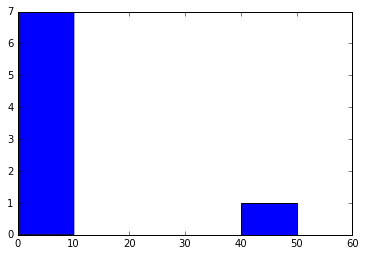

In [41]:
plt.hist(measurements[:,0], bins=5)

The first bin contains about the same number of samples from both classes. We need a better solution. Hence: Compute the entropy for the candidate boundaries T = 0.5, T = 0.95, T = 2.5. Which boundary
gives the best discretization? Use that boundary to discretize the data.

In [47]:
def split(array, cond, axis=0):
    # helper for conditional slicing
    index = 0
    for x in array[:,axis]:
        if not cond(x):
            break
        index += 1
    return np.split(array, [index], axis=axis)

def entropy(partition):
    labels = np.unique(partition[:,1])
    counts = [sum(1 for x in filter(lambda x: x == label, partition[:,1])) for label in labels]
    entropy = 0
    for label,count in zip(labels,counts):
        probability = count / sum(x for x in counts)
        entropy -= probability * math.log(probability, 2)
    return entropy

def info(dataset, threshold):
    # combined entropy based on bin-weight
    part1, part2 = split(dataset, lambda x: x < threshold, axis=0)
    return len(part1) / len(dataset) * entropy(part1) + len(part2) / len(dataset) * entropy(part2)

tresholds = [0.5, 0.95, 2.5]
infos = [info(measurements, t) for t in tresholds]
print(infos)
initial_entropy = entropy(measurements)
gains = [initial_entropy - info for info in infos]
print(gains)


[0.7382124193598535, 0.9162583131090227, 0.8999329589909884]
[0.1984549625177091, 0.020409068768539873, 0.03673442288657425]


Now discretize based on highest information gain:

(array([ 2.,  6.]), array([  0.1,   0.5,  50. ]), <a list of 2 Patch objects>)

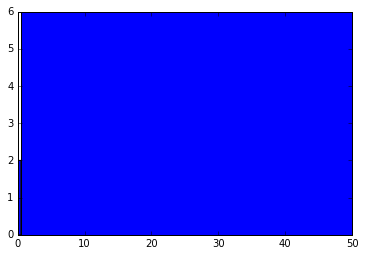

In [43]:
best_treshold = tresholds[gains.index(max(gains))]
interval = np.min(measurements[:,0]), best_treshold, np.max(measurements[:,0])
plt.hist(measurements[:,0], bins=interval)

This leaves us with almost completely pure bins (only a single fail in the second bin).

Finding the best split
-------------------------

To find the best split, we recursively average two neighboring values in the list and select the split with the highest information gain.

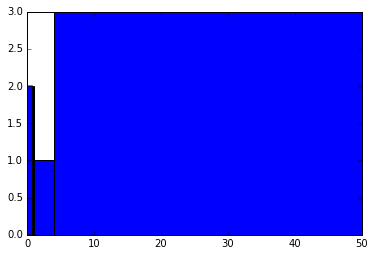

In [44]:
split_indices = []

def best_split(partition, entropy):
    highest_gain = 0
    split_index = -1
    for i, v in enumerate(partition[:,0]):
        if i >= len(partition[:,0]) - 1:
            break
        next_v = partition[:,0][i+1]
        avg = (v + next_v) / 2
        new_entropy = info(partition, avg)
        gain = entropy - new_entropy
        if gain > highest_gain:
            highest_gain = gain
            split_index = i + 1
    return split_index, highest_gain
            
def fit_bins(dataset, start_index=0, max_gain=0.05):
    current_entropy = entropy(dataset)
    split_index, gain = best_split(dataset, current_entropy)
    if gain > max_gain:
        split_indices.append(start_index + split_index)
        part1, part2 = np.split(dataset, [split_index], axis=0)
        fit_bins(part1, start_index, max_gain)
        fit_bins(part2, start_index + split_index, max_gain)

def plot_bins(dataset, max_gain):
    fit_bins(dataset, max_gain=max_gain)
    start = 0.0
    end = dataset[:,0][len(dataset)-1]
    intervals = sorted([start] + [dataset[:,0][index] for index in split_indices] + [end])
    plt.hist(dataset[:,0], bins=intervals)

plot_bins(measurements, max_gain=0.15)

Entropy tolerance
------------------
The algorithm implements an information gain threshold as the stopping criterion, which allows us to control the purity i.e. granularity of the bins. The binning will be more tolerant towards high-entropy bins (with multiple classes) if this value is high. Consider the following examples for a slightly larger dataset:

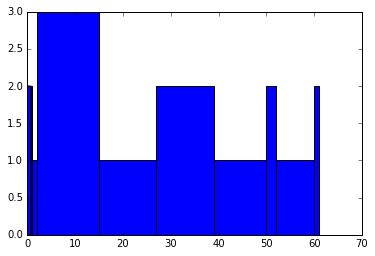

In [45]:
measurements = np.array([[0.1, 0], [0.2, 0], [0.8, 1], [0.9, 1], [1.0, 0], [2.0, 1], [4.0, 1], [10.0, 1], [15.0, 0], [27.0, 1], [29.0, 1], [39,0], [50.0, 1], [51.0, 1], [52.0, 0], [60.0, 1], [61.0, 1]]).astype(float)
split_indices = []
plot_bins(measurements, max_gain=0.01) # high granularity

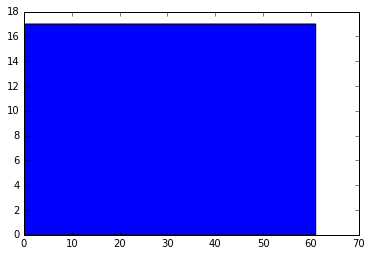

In [46]:
split_indices = []
plot_bins(measurements, max_gain=0.5) # low granularity